# Importing Packages

In [1]:
# Calculate
import math
import numpy as np
import bezier

# Visualize
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Path planning
from dijkstar import Graph, find_path

# Utils

In [2]:
def curve_fukuro(robot_coordinate):
    control_points = robot_coordinate.T
    
    num_points = 10
    t_values = np.linspace(0.0, 1.0, num_points)
    
    curve = bezier.Curve(control_points, degree=len(control_points[0])-1)
    curve_points = curve.evaluate_multi(t_values)
    length = curve.length
    
    return curve_points, control_points, length


def bezier_visualizer(curve_points, control_points, robot_coordinate=None):
    plt.figure()
    plt.plot(*curve_points, label="Bezier Curve")
    plt.scatter(control_points[0], control_points[1], color="r", label="Control Points")
    if robot_coordinate is not None:
        plt.scatter(robot_coordinate.T[0], robot_coordinate.T[1], color="b", label="Robot Coordinate")
    plt.xlabel("Length")
    plt.ylabel("Width")
    plt.xlim([0, 2200])
    plt.ylim([0, 1400])
    plt.legend()
    plt.show()

# 1. Bezier Curve

In [3]:
x = np.random.randint(0, 2200, (10, 1))
y = np.random.randint(0, 1400, (10, 1))

robot_coordinate = np.append(x, y, axis=1)

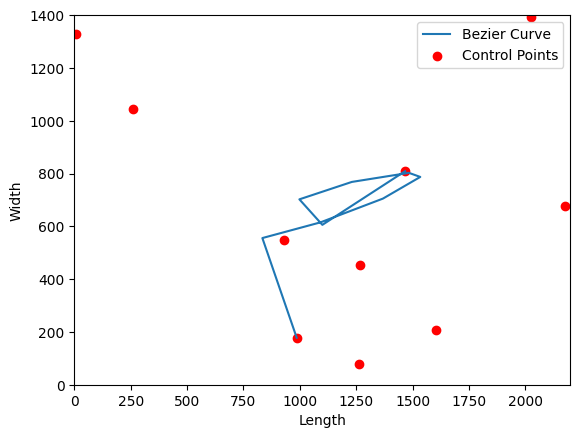

In [4]:
# Calculate The Bezier Curve
curve_points, control_points, length = curve_fukuro(robot_coordinate)

# Curve Visualizing
bezier_visualizer(curve_points, control_points)

## Namun terdapat kekurangan jika mempertimbangkan seluruh koordinat, maka voronoi diagram menjadi solusi yang dipilih

# 2. Voronoi Diagram

In [5]:
def plot_voronoi(robot_coordinate):
    vor = Voronoi(robot_coordinate)
    fig = voronoi_plot_2d(vor)
    
    for ridge in vor.ridge_vertices:
        if -1 not in ridge:
            line_segment = vor.vertices[ridge]
            midpoint = np.mean(line_segment, axis=0)
            length = np.linalg.norm(line_segment[1] - line_segment[0])
            if 0 <= midpoint[0] <= 2200 and 0 <= midpoint[1] <= 1400:
                plt.text(midpoint[0], midpoint[1], f'{length:.2f}', ha='center', va='bottom')

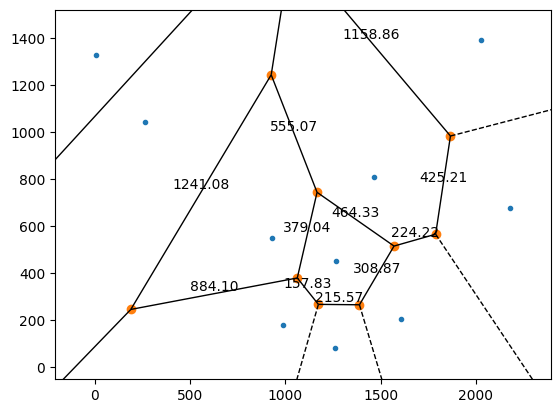

In [6]:
plot_voronoi(robot_coordinate)

## Gunakan weight yang masing masing jalur lalu hitung dengan dijkstar algorithm

# 3. Path Planning

In [7]:
def dijkstar_voronoi(robot_coordinate, start_point, end_point):
    vor = Voronoi(robot_coordinate)
    vertices = vor.vertices
    
    graph = Graph()
    
    # Add edges based on Voronoi vertices
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            for i in range(len(region)):
                v1 = vertices[region[i]]
                v2 = vertices[region[(i + 1) % len(region)]]
                distance = ((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)**0.5
                graph.add_edge(region[i], region[(i + 1) % len(region)], distance)

    # Find index of nearest Voronoi vertex to the user-defined start and end points
    start_index = min(range(len(vertices)), key=lambda i: ((vertices[i][0] - start_point[0])**2 + (vertices[i][1] - start_point[1])**2))
    end_index = min(range(len(vertices)), key=lambda i: ((vertices[i][0] - end_point[0])**2 + (vertices[i][1] - end_point[1])**2))

    # Find shortest path using Dijkstra's algorithm
    shortest_path = find_path(graph, start_index, end_index)
    shortest_path_coordinates = [list(vertices[node]) for node in shortest_path.nodes]
    shortest_path_coordinates.insert(0, start_point)
    shortest_path_coordinates.append(end_point)
    
    return vor, vertices, shortest_path, shortest_path_coordinates

In [8]:
start_point = [robot_coordinate[6][0], robot_coordinate[6][1]]
end_point = [robot_coordinate[4][0], robot_coordinate[4][1]]

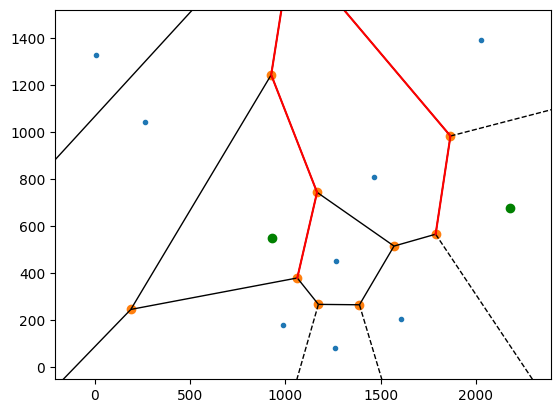

In [9]:
vor, vertices, shortest_path, shortest_path_coordinates = dijkstar_voronoi(robot_coordinate, start_point, end_point)

# Plot Voronoi diagram
voronoi_plot_2d(vor)
plt.plot([vertices[node][0] for node in shortest_path.nodes], [vertices[node][1] for node in shortest_path.nodes], 'r-')
plt.plot(start_point[0], start_point[1], color="green", marker="o")  # Plot start point
plt.plot(end_point[0], end_point[1], color="green", marker="o") # Plot end point
plt.show()

In [10]:
bezier_point = np.array(shortest_path_coordinates)

# HASIL

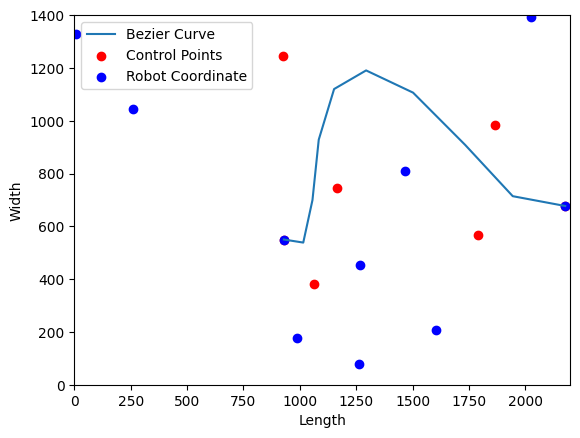

Panjang lintasan curve: 1940.0422380748914


In [11]:
curve_points, control_points, length = curve_fukuro(bezier_point)

# Plot the Bezier curve and control points
bezier_visualizer(curve_points, control_points, robot_coordinate=robot_coordinate)
print(f"Panjang lintasan curve: {length}")